<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Tutorial 10: Credit Risk Application</h2>
<br>

In this tutorial we discuss how we can use classification in the context of a business decision-making problem. 

<a href="#1.-German-Credit-Data">German Credit Data</a> <br>
<a href="#2.-Decision-Analysis">Decision Analysis</a> <br>
<a href="#3.-Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a href="#4.-Feature-Engineering">Feature Engineering</a> <br>
<a href="#5.-Logistic-Regression">Logistic Regression</a> <br>
<a href="#6.-Probability-Calibration">Probability Calibration</a> <br>
<a href="#7.-Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Model selection and evaluation tools
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, log_loss

### 1. German Credit Data

This tutorial is based on the [German Credit Data](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) available from the UCI Machine Learning repository. Each observation in the dataset represents a loan. The response variable is `default`, which indicates whether the client defaulted on the loan. 

In [4]:
data = pd.read_csv('Data/german_credit.csv')
data.head()

,status,duration,history,purpose,amount,savings,employment,installment_rate,personal,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_under_maintenance,telephone,foreign_worker,default
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,1,1,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,0,1,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,0,1,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,0,1,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,0,1,1


There are 13 categorical predictors (two of them binary and already coded numerically) and 7 numerical predictors in the dataset. Refer to the [documentation](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) for the explanation of the variables and the meaning of the levels for the categorical variables. 

In [5]:
variables = pd.read_csv('Data/german_credit_variables.csv', index_col='variable')
variables = variables['type']

continuous = variables[variables == 'continuous'].index.tolist()
discrete = variables[variables == 'discrete'].index.tolist()
categorical = variables[variables == 'categorical'].index.tolist()
binary = variables[variables == 'binary'].index.tolist()
response = variables[variables == 'response'].index.tolist()
   
variables.value_counts()

categorical    11
discrete        4
continuous      3
binary          2
response        1
Name: type, dtype: int64

As always, we need to split the data before exploratory data analysis. For now we only need to create the unprocessed training dataset. 

In [6]:
index_train, index_test  = train_test_split(np.array(data.index), stratify=data[response], 
                                            train_size=0.7, random_state=5)
train = data.loc[index_train,:].copy()

### 2. Decision Analysis

The data documentation suggests the following loss matrix: 

<table>
  <tr>
    <th>Predicted / Actual</th>
    <th>Good credit</th>
     <th>Default</th>
  </tr>
  <tr>
    <th>Good credit</th>
    <td>0</td>
    <td>5</td>
  </tr>
  <tr>
    <th>Default</th>
    <td>1</td>
    <td>0</td>
  </tr>
</table>

That is, if we predict a default but the customer is a good credit, the loss is 1.  If we predict that the customer is a good credit but there is a default, the loss is 5. The loss for a correct classification is 0. In the terminology of the lectures, the loss from a false positive is 1, the loss from a false negative is 5, and the loss from both true positives and true negatives is zero. 

Using the formula from the lectures, the decision threshold is therefore: 

In [7]:
tau = 1/(1+5)
print(f'Decision threshold: tau={round(tau,3)}')

Decision threshold: tau=0.167


### 3. Exploratory Data Analysis

Defaults correspond to 30% of observations in the training data. 

In [8]:
train['default'].value_counts(normalize=True)

0    0.7
1    0.3
Name: default, dtype: float64

The descriptive statistics allows us to verify that there are no missing values or apparent errors in the numerical variables.

In [9]:
train.describe().round(2)

,duration,amount,installment_rate,residence,age,existing_credits,people_under_maintenance,telephone,foreign_worker,default
count,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00
mean,21.12,3346.50,2.97,2.84,35.67,1.43,1.16,0.41,0.97,0.30
std,12.26,2870.26,1.13,1.11,11.60,0.59,0.37,0.49,0.18,0.46
min,4.00,250.00,1.00,1.00,20.00,1.00,1.00,0.00,0.00,0.00
25%,12.00,1364.00,2.00,2.00,27.00,1.00,1.00,0.00,1.00,0.00
50%,18.00,2339.50,3.00,3.00,33.00,1.00,1.00,0.00,1.00,0.00
75%,24.00,4151.50,4.00,4.00,42.00,2.00,1.00,1.00,1.00,1.00
max,60.00,15945.00,4.00,4.00,75.00,4.00,2.00,1.00,1.00,1.00


As common in this type of data, some of the continuous variables are skewed. 

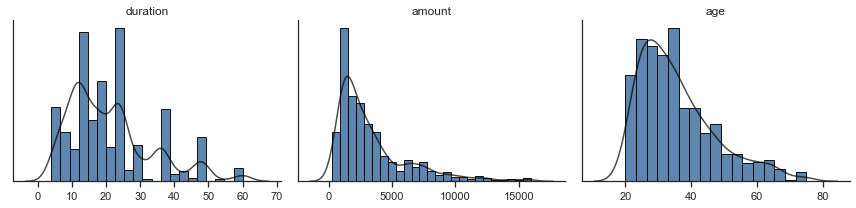

In [10]:
from statlearning import plot_dists
plot_dists(train[continuous]) 
plt.show()

The duration and amount of the loan seem to have a relevant positive association with the default rates.

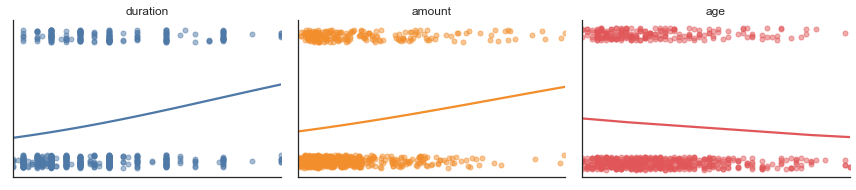

In [11]:
from statlearning import plot_logistic_regressions
fig, ax = plot_logistic_regressions(train[continuous], train['default'])
plt.show()

The following bar plots allow us to visualise the relationship between defaults and the remaining variables. Certain variables, such as the status of existing checking account, saving, credit history, and whether the client is a foreign worker, seem to have an important association with default rates.

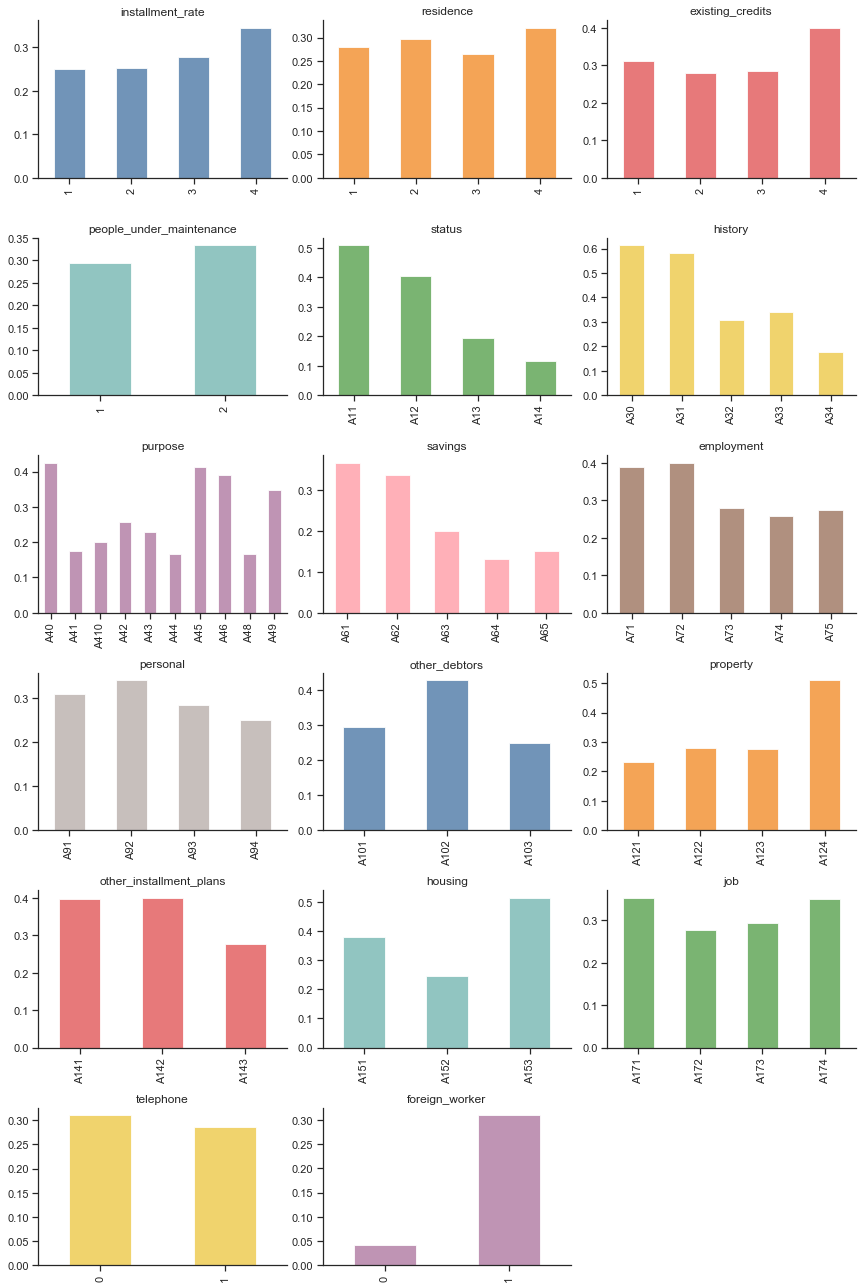

In [12]:
from statlearning import crosstabplots
crosstabplots(train[discrete + categorical + binary], train['default'])
plt.show()

### 4. Feature Engineering

We create a function that implements the feature engineering process belows. Here are the key details: 

1. We treat the discrete variables in the same way as categorical variables (since they only have a few possible values).

2. The function allows for dummy or one-hot encoding for experimentation. You can verify that one-hot encoding works best for this problem.

3. We consider a Yeo-Johnson transformation of the credit amount and age. The code allows you to verify that not doing the transformations negatively impacts the performance of the classifiers. 

4. We standardise the predictors. 

In [13]:
from sklearn.preprocessing import PowerTransformer, StandardScaler

def feat_engineering(original_data, variables, index_train, index_test, transformation=True, 
                              one_hot=False):
    
    data = original_data.copy()
    
    continuous = variables[variables == 'continuous'].index.tolist()
    discrete = variables[variables == 'discrete'].index.tolist()
    categorical = variables[variables == 'categorical'].index.tolist()
    binary = variables[variables == 'binary'].index.tolist()
    response = variables[variables == 'response'].index.tolist()
    
    # Dummy or one-hot encoding for all discrete and categorical variables
    labels = discrete + categorical 
    for label in labels:
        dummies = pd.get_dummies(data[label], prefix=label, drop_first=not one_hot)
        data = data.join(dummies)
        binary += list(dummies.columns)
    
    # Yeo-Johnson transformation
    transf = ['amount', 'age']
    if transformation: 
        yj_transf = PowerTransformer(method='yeo-johnson').fit(data.loc[index_train, transf])
        data[transf] = yj_transf.transform(data[transf])
    
    predictors = continuous + binary
    scaler = StandardScaler().fit(data.loc[index_train, predictors])
    data[predictors] = scaler.transform(data[predictors])
    
    X_train = data.loc[index_train, predictors].to_numpy()
    X_test = data.loc[index_test, predictors].to_numpy()

    y_train = data.loc[index_train, response].to_numpy()
    y_test = data.loc[index_test, response].to_numpy()
    
    return X_train, np.ravel(y_train), X_test, np.ravel(y_test), predictors

X_train, y_train, X_test, y_test, predictors = feat_engineering(data, variables, index_train, index_test,
                                                             transformation=True, one_hot=True)

### 5. Logistic Regression

We consider the logistic regression model with different types of regularisation. For computational reasons (see the next part), we first use `LogisticRegressionCV` for hyperparameter optimisation, and then fit the models again based on the best penalties. 

In [14]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


X_train, y_train, X_test, y_test, predictors = feat_engineering(data, variables, index_train, index_test,
                                                             transformation = True, one_hot=True)

# Logistic regression without regularisation
# Note: we shouldn't use one-hot encoding here due to multicollinearity, but the implementation 
# is sufficienty robust so that this does not cause a problem in this case.
logit = LogisticRegression(C=np.inf, solver='lbfgs')
logit.fit(X_train, y_train)

# Select the penalties by cross-validation
logit_l1= LogisticRegressionCV(Cs = 50, penalty='l1', solver='liblinear', scoring='neg_log_loss')
logit_l2= LogisticRegressionCV(Cs = 50, penalty='l2', solver='lbfgs', scoring='neg_log_loss')

logit_l1.fit(X_train, y_train)
logit_l2.fit(X_train, y_train)

# Refit the models using the best penalty
logit_l1= LogisticRegression(C = logit_l1.C_[0], penalty='l1', solver='liblinear')
logit_l2= LogisticRegression(C = logit_l2.C_[0], penalty='l2', solver='lbfgs')

logit_l1.fit(X_train, y_train)
logit_l2.fit(X_train, y_train)

LogisticRegression(C=0.019306977288832496, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

Next, we use `cross_val_predict` to conduct a detailed analysis of the predictive performance of each method, so that we can select the final approach for the test data. We find that the model based on $\ell_2$ regularisation performs best in terms of the actual loss. In this situation the ideal would be the conduct a hypothesis test to verify this finding statistically, since  $\ell_1$ regularisation performs best in terms of AUC and the cross-entropy.

For simplicity, we select the logistic regression model with $\ell_2$ regularisation.

In [15]:
from sklearn.model_selection import cross_val_predict

columns=['Loss', 'SE', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['Logistic', 'Logistic $\ell_1$', 'Logistic $\ell_2$']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, logit_l1, logit_l2]
y_prob = np.zeros((len(y_train), len(rows)))

for i, method in enumerate(methods):
    
    y_prob[:, i] = cross_val_predict(method, X_train, y_train, cv = 10, method='predict_proba')[:,1]
    y_pred = (y_prob[:, i] > tau).astype(int)
    
    loss =  5*((y_pred!=y_train) & (y_pred==0)) + 1*((y_pred!=y_train) & (y_pred==1))
    
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel() 

    results.iloc[i,0] =  np.mean(loss) # or (fp*1+fn*5)/len(y_test)
    results.iloc[i,1] =  np.std(loss)/np.sqrt(len(y_train)) # standard error 
    results.iloc[i,2] =  tp/(tp+fn)
    results.iloc[i,3] =  tn/(tn+fp)
    results.iloc[i,4] =  precision_score(y_train, y_pred)
    results.iloc[i,5] =  roc_auc_score(y_train, y_prob[:,i])
    results.iloc[i,6] =  log_loss(y_train, y_prob[:,i])
   

results.round(3)

,Loss,SE,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Logistic,0.609,0.045,0.805,0.549,0.433,0.763,0.615
Logistic $\ell_1$,0.564,0.036,0.890,0.429,0.400,0.785,0.500
Logistic $\ell_2$,0.553,0.035,0.895,0.435,0.404,0.781,0.501


The next figures shows the largest estimated coefficients. 

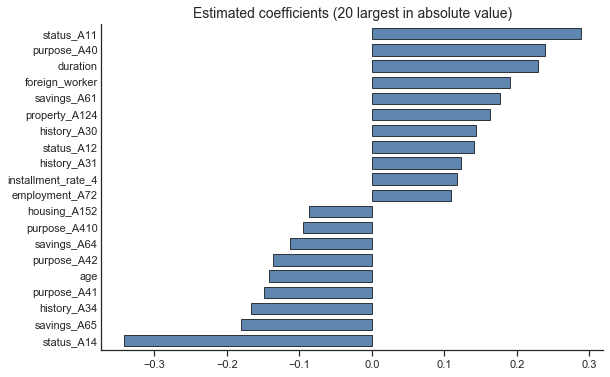

In [16]:
from statlearning import plot_coefficients
plot_coefficients(logit_l2, predictors)
plt.show()

### 6. Probability Calibration

The next cell plots the probability calibration curves (reliability curves). The function is based on the [calibration_curve](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html#sklearn.calibration.calibration_curve) function from scikit-learn. In this type of application, we're particularly concerned with the accuracy of the estimated probabilities near the decision threshold. 

The figure suggest that the $\ell_1$ and $\ell_2$ regularised models are well calibrated near the threshold. In contrast, the logistic regression model seems to underestimate the probabilities near the threshold. This causes it to classify too many many loans as good credit and not enough as default (we can see this from the table above). 

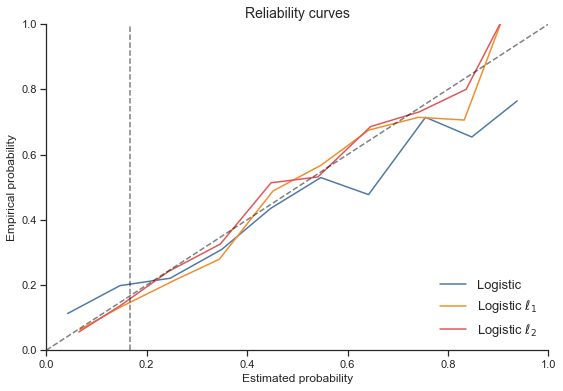

In [17]:
from statlearning import plot_calibration_curves
fig, ax = plot_calibration_curves(y_train, y_prob, labels=rows)
ax.axvline(tau, color='black', linestyle='dashed', alpha = 0.5) # decision threshold
plt.show()

It's often useful to a probability calibration method to try to correct systematic errors near threshold. The [CalibratedClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV) from scikit-learn allows us to this, with the caveat the we need to be careful to avoid overfitting.

Even though we don't have much to gain here (since our chosen model already seems to be well-calibrated), we implement this approach for illustration.

In [18]:
from sklearn.calibration import CalibratedClassifierCV

logit_cal = CalibratedClassifierCV(logit_l2, cv = 10, method='sigmoid') 
logit_cal.fit(X_train, y_train)

# note: method='isotonic' can work well with lots of data

CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.019306977288832496, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
            cv=10, method='sigmoid')

### 7. Model Evaluation

We find that the logistic regression model with $\ell_2$ regularisation is indeed the best approach for the test data, measured in terms of the actual loss (and hence business performance). The loss is 15% lower than the logistic regression benchmark. 


In [19]:
columns=['Loss', 'SE', 'Sensitivity', 'Specificity', 'Precision', 'AUC',  'Cross-entropy']
rows=['Logistic', 'Logistic $\ell_1$', 'Logistic $\ell_2$', 'Logistic $\ell_2$ (calibrated)']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, logit_l1, logit_l2, logit_cal]
y_test = np.ravel(y_test)

y_prob = np.zeros((len(y_test), len(rows)))

for i, method in enumerate(methods):
    
    y_prob[:, i] = method.predict_proba(X_test)[:,1]
    y_pred = (y_prob[:, i] > tau).astype(int)
    
    loss =  5*((y_pred!=y_test) & (y_pred==0)) + 1*((y_pred!=y_test) & (y_pred==1))
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 

    results.iloc[i,0] =  np.mean(loss) # or (fp*1+fn*5)/len(y_test)
    results.iloc[i,1] =  np.std(loss)/np.sqrt(len(y_test))
    results.iloc[i,2] =  tp/(tp+fn)
    results.iloc[i,3] =  tn/(tn+fp)
    results.iloc[i,4] =  precision_score(y_test, y_pred)
    results.iloc[i,5] =  roc_auc_score(y_test, y_prob[:,i])
    results.iloc[i,6] =  log_loss(y_test, y_prob[:,i])
   

results.round(3)

,Loss,SE,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Logistic,0.670,0.072,0.778,0.519,0.409,0.737,0.555
Logistic $\ell_1$,0.603,0.053,0.900,0.352,0.373,0.741,0.526
Logistic $\ell_2$,0.573,0.055,0.889,0.419,0.396,0.751,0.520
Logistic $\ell_2$ (calibrated),0.567,0.051,0.911,0.381,0.387,0.751,0.520


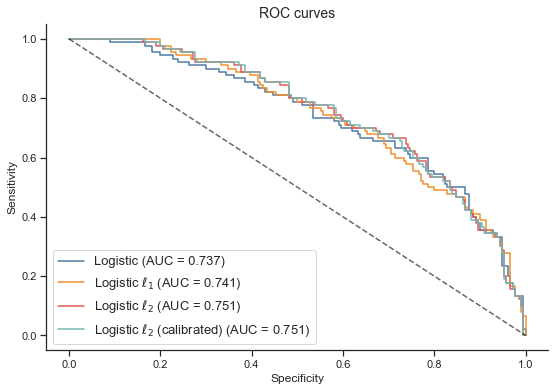

In [20]:
from statlearning import plot_roc_curves

fig, ax = plot_roc_curves(y_test, y_prob, labels=pd.Series(rows))
plt.show()

### Formatting

These two cells below format the notebook for display online. Please omit them from your work.

In [21]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [22]:
from IPython.core.display import HTML
style = open('css\jupyter.css', "r").read()
HTML('<style>'+ style +'</style>')